# Construct Valeos Inpatient Database from CLIF
## Filter CLIF tables to transplant patients and their hospitalizations

In [1]:
import pandas as pd
import sys
import os
from pathlib import Path

# Add utils directory to path
sys.path.append('../utils')
from config import load_config

Loaded configuration from config.json


In [2]:
# Load configuration
config = load_config()
print(f"Site: {config['site_name']}")
print(f"Tables path: {config['tables_path']}")
print(f"File type: {config['file_type']}")

Loaded configuration from config.json
Site: University of Chicago
Tables path: /Users/williamparker/Desktop/CLIF_tables
File type: parquet


## Step 2: Load Transplant Patient IDs 

In [3]:
# load in transplant_df.csv
transplant_df = pd.read_csv('/Users/williamparker/Desktop/CLIF_tables/unique_enc_pat.csv')

#drop hospitalization_id column
transplant_df = transplant_df.drop(columns=['hospitalization_id'])

#drop duplicate rows
transplant_df = transplant_df.drop_duplicates()

# Get unique transplant patient IDs from the CSV
transplant_patient_ids = transplant_df['patient_id'].unique()
print(f"Number of unique transplant patient IDs: {len(transplant_patient_ids)}")
print(f"Sample patient IDs: {transplant_patient_ids[:5]}")

# Convert patient IDs to string for consistent matc`hing
transplant_patient_ids_str = [str(pid) for pid in transplant_patient_ids]

#rename service_date to transplant_date
transplant_df = transplant_df.rename(columns={'service_date': 'transplant_date'})

#arrange columns in order of patient_id, transplant_date, transplant_type
transplant_df = transplant_df[['patient_id', 'transplant_date', 'organ']]

#create a new column called transplant number that is a running number of the transplant for each patient
transplant_df['transplant_number'] = transplant_df.groupby('patient_id').cumcount() + 1

#create a new column that is total number of transplants for each patient
transplant_df['total_transplants'] = transplant_df.groupby('patient_id')['patient_id'].transform('count')

# heart transplant recipient ids
heart_transplant_ids = transplant_df[transplant_df['organ'] == 'heart']['patient_id'].unique()
print(f"Number of unique heart transplant patient IDs: {len(heart_transplant_ids)}")
print(f"Sample heart transplant patient IDs: {heart_transplant_ids[:5]}")

# lung transplant recipient ids
lung_transplant_ids = transplant_df[transplant_df['organ'] == 'lung']['patient_id'].unique()
print(f"Number of unique lung transplant patient IDs: {len(lung_transplant_ids)}")
print(f"Sample lung transplant patient IDs: {lung_transplant_ids[:5]}")

# liver transplant recipient ids
liver_transplant_ids = transplant_df[transplant_df['organ'] == 'liver']['patient_id'].unique()
print(f"Number of unique liver transplant patient IDs: {len(liver_transplant_ids)}")
print(f"Sample liver transplant patient IDs: {liver_transplant_ids[:5]}")

# kidney transplant recipient ids
kidney_transplant_ids = transplant_df[transplant_df['organ'] == 'kidney']['patient_id'].unique()
print(f"Number of unique kidney transplant patient IDs: {len(kidney_transplant_ids)}")
print(f"Sample kidney transplant patient IDs: {kidney_transplant_ids[:5]}") 

Number of unique transplant patient IDs: 1410
Sample patient IDs: [ 43154  41928  32590  94310 107128]
Number of unique heart transplant patient IDs: 351
Sample heart transplant patient IDs: [43154 82646 99226 28346 26790]
Number of unique lung transplant patient IDs: 87
Sample lung transplant patient IDs: [ 41928 100786  75992  60834  73088]
Number of unique liver transplant patient IDs: 442
Sample liver transplant patient IDs: [ 94310 100106  20232  77264  29934]
Number of unique kidney transplant patient IDs: 651
Sample kidney transplant patient IDs: [ 32590 107128  36182  77620 114015]


In [4]:
# tabulate transplant patient types 
transplant_df['organ'].value_counts()


organ
kidney    658
liver     455
heart     359
lung       90
Name: count, dtype: int64

## Step 3: Filter Patient Table to Transplant Recipients

In [5]:
def load_clif_table(table_name, config):
    """Load a CLIF table based on configuration"""
    tables_path = Path(config['tables_path'])
    file_type = config['file_type']
    file_path = tables_path / f"{table_name}.{file_type}"

    if not file_path.exists():
        print(f"Warning: {file_path} not found")
        return None

    try:
        if file_type == 'csv':
            return pd.read_csv(file_path)
        elif file_type == 'parquet':
            return pd.read_parquet(file_path)
        else:
            raise ValueError(f"Unsupported file type: {file_type}")
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

# Load the patient table
print("Loading CLIF patient table...")
patient_df = load_clif_table('clif_patient', config)


#filter the patient_df to just transplant_patient_ids_str
patient_df = patient_df[patient_df['patient_id'].astype(str).isin(transplant_patient_ids_str)]

patient_df.shape

Loading CLIF patient table...


(1410, 11)

In [ ]:
# load in hospitalization table and filter to transplant recipients
hospitalization_df = load_clif_table('clif_hospitalization', config)


#filter to transplant recipients by patient_id
hospitalization_df = hospitalization_df[hospitalization_df['patient_id'].isin(transplant_patient_ids_str)]

print(f"number of hospitilizations for transplant recipients: {len(hospitalization_df)}")

#count hospitalizations per patient
hospitalization_df['hospitalization_count'] = hospitalization_df.groupby('patient_id')['patient_id'].transform('count')

#check that all transplant recipients have at least one hospitalization
len(hospitalization_df['patient_id'].unique())


number of hospitilizations for transplant recipients: 4600


1410

In [27]:
len(transplant_patient_ids_str)

1410

In [28]:
# Load continuous medication admin
med_cont_path = os.path.join(config['tables_path'], f"clif_medication_admin_continuous.{config['file_type']}")
print(f"Loading continuous medication admin from: {med_cont_path}")

if config['file_type'] == 'parquet':
    med_cont_df = pd.read_parquet(med_cont_path)
else:
    med_cont_df = pd.read_csv(med_cont_path)

print(f"Continuous medication admin loaded: {len(med_cont_df)} rows")
print(f"Columns: {list(med_cont_df.columns)}")
print("\nFirst few rows:")
print(med_cont_df.head())

Loading continuous medication admin from: /Users/williamparker/Desktop/CLIF_tables/clif_medication_admin_continuous.parquet
Continuous medication admin loaded: 6386462 rows
Columns: ['hospitalization_id', 'admin_dttm', 'med_name', 'med_category', 'med_group', 'med_route_name', 'med_dose', 'med_dose_unit', 'mar_action_name']

First few rows:
  hospitalization_id                admin_dttm  \
0          632378907 2022-02-10 18:00:00+00:00   
1          632378907 2022-02-10 18:16:00+00:00   
2          632378907 2022-02-10 18:26:00+00:00   
3          632378907 2022-02-10 18:35:00+00:00   
4          632378975 2022-03-01 18:23:00+00:00   

                                            med_name    med_category  \
0             PROPOFOL 10 MG/ML INTRAVENOUS EMULSION        propofol   
1             PROPOFOL 10 MG/ML INTRAVENOUS EMULSION        propofol   
2             PROPOFOL 10 MG/ML INTRAVENOUS EMULSION        propofol   
3             PROPOFOL 10 MG/ML INTRAVENOUS EMULSION        propofol

In [29]:
# Load in vitals table
vitals_df = load_clif_table('clif_vitals', config)

# filter to hospitalizations in hospitalization_df
vitals_df = vitals_df[vitals_df['hospitalization_id'].isin(hospitalization_df['hospitalization_id'])]


In [ ]:
# create a table with first_vital_dttm and last_vital_dttm for each hospitalization
vital_start_stop = vitals_df.groupby('hospitalization_id').agg({'recorded_dttm': ['min', 'max']}).reset_index()
vital_start_stop.columns = ['hospitalization_id', 'first_vital_dttm', 'last_vital_dttm']


#merge with hospitalization_df
hospitalization_df = pd.merge(hospitalization_df, vital_start_stop, on='hospitalization_id', how='left')

hospitalization_df



,patient_id,hospitalization_id,hospitalization_joined_id,admission_dttm,discharge_dttm,age_at_admission,admission_type_name,admission_type_category,discharge_name,discharge_category,zipcode_nine_digit,zipcode_five_digit,state_code,prev_discharge_dttm,prev_admission_dttm,prev_hospitalization_id,gap_from_prev,hospitalization_count,first_vital_dttm,last_vital_dttm
0,100024,633246295,None,2020-05-19 11:00:00+00:00,2020-05-25 20:18:00+00:00,46,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged to Home or Self Care (Routine Disch...,Home,None,60093,IL,NaT,NaT,None,NaT,1,2020-05-19 13:24:00+00:00,2020-05-25 17:34:00+00:00
1,100105,644763560,None,2019-08-19 16:40:00+00:00,2019-08-23 15:55:00+00:00,38,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged to Home or Self Care (Routine Disch...,Home,None,60104,IL,NaT,NaT,None,NaT,2,2019-08-19 17:45:00+00:00,2019-08-23 15:17:00+00:00
2,100105,645894610,None,2023-06-10 14:41:00+00:00,2023-06-13 17:04:00+00:00,42,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged to Home or Self Care (Routine Disch...,Home,None,60104,IL,2019-08-23 15:55:00+00:00,2019-08-19 16:40:00+00:00,644763560,1386 days 22:46:00,2,2023-06-10 15:00:00+00:00,2023-06-13 16:55:00+00:00
3,100106,633377837,None,2018-01-03 22:03:00+00:00,2018-02-05 20:36:00+00:00,67,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged/transferred to an Inpatient Rehab F...,Acute Inpatient Rehab Facility,None,60652,IL,NaT,NaT,None,NaT,12,2018-01-03 22:04:00+00:00,2018-02-05 18:00:00+00:00
4,100106,642707482,None,2018-02-16 10:12:00+00:00,2018-02-22 20:14:00+00:00,68,Transfer from a Hospital (Different Facility),Other,Discharged/transferred to an Inpatient Rehab F...,Acute Inpatient Rehab Facility,None,60652,IL,2018-02-05 20:36:00+00:00,2018-01-03 22:03:00+00:00,633377837,10 days 13:36:00,12,2018-02-16 10:15:00+00:00,2018-02-22 19:36:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,99948,644532308,None,2022-05-12 23:49:00+00:00,2022-05-19 21:09:00+00:00,60,Clinic or Physician's Office,Other,Discharged to Home or Self Care (Routine Disch...,Home,604519202,60451,IL,2022-04-08 18:59:00+00:00,2022-03-24 22:50:00+00:00,632555669,34 days 04:50:00,7,2022-05-12 23:57:00+00:00,2022-05-19 16:00:00+00:00
4596,99948,645139990,None,2022-07-19 23:05:00+00:00,2022-07-30 20:06:00+00:00,60,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged/transferred to Skilled Nursing Faci...,Skilled Nursing Facility,604519202,60451,IL,2022-05-19 21:09:00+00:00,2022-05-12 23:49:00+00:00,644532308,61 days 01:56:00,7,2022-07-19 23:11:00+00:00,2022-07-30 00:55:00+00:00
4597,99948,646365502,None,2022-08-03 02:30:00+00:00,2022-08-21 17:09:00+00:00,60,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged/transferred to an Inpatient Rehab F...,Acute Inpatient Rehab Facility,604519202,60451,IL,2022-07-30 20:06:00+00:00,2022-07-19 23:05:00+00:00,645139990,3 days 06:24:00,7,2022-08-03 02:45:00+00:00,2022-08-21 13:19:00+00:00
4598,99948,645327764,None,2022-10-20 22:14:00+00:00,2022-11-02 20:53:00+00:00,60,Non-Health Care Facility Point of Origin,Long Term Care Hospital (LTACH),Discharged/transferred to an Inpatient Rehab F...,Acute Inpatient Rehab Facility,604519202,60451,IL,2022-08-21 17:09:00+00:00,2022-08-03 02:30:00+00:00,646365502,60 days 05:05:00,7,2022-10-20 15:41:00+00:00,2022-11-02 18:03:00+00:00


# Identify transplant hospitalization

Using the transplant_date in the transplant table, identify the hospitalization which has the transplant_date between the start and end dates.b

In [8]:
transplant_df['patient_id'] = transplant_df['patient_id'].astype(str)
hospitalization_df['patient_id'] = hospitalization_df['patient_id'].astype(str)



# create transplant_hospitalization by identifying the hospitalization where the transplant_date falls between admission_dttm and discharge_dttm for each transplant recipient

transplant_hospitalization = pd.merge(hospitalization_df,transplant_df, on='patient_id', how='left')
transplant_hospitalization = transplant_hospitalization[transplant_hospitalization['admission_dttm'] < transplant_hospitalization['transplant_date']]
transplant_hospitalization = transplant_hospitalization[transplant_hospitalization['discharge_dttm'] >= transplant_hospitalization['transplant_date']]

transplant_hospitalization.shape


# identify patient_ids in transplant_df but not in transplant_hospitalization
missing_hosp = transplant_df[~transplant_df['patient_id'].isin(transplant_hospitalization['patient_id'])]


# display transplant_df for missing_hosp
transplant_df[transplant_df['patient_id'].isin(missing_hosp['patient_id'])]



,patient_id,transplant_date,organ,transplant_number,total_transplants
0,43154,2018-01-03 06:00:00+00:00,heart,1,1
8,107128,2018-01-17 06:00:00+00:00,kidney,1,1
23,36182,2018-01-28 06:00:00+00:00,kidney,1,1
29,77620,2018-02-06 06:00:00+00:00,kidney,1,1
39,20232,2018-02-19 06:00:00+00:00,liver,1,1
...,...,...,...,...,...
5212,205433,2024-12-12 06:00:00+00:00,liver,1,1
5214,226089,2024-12-16 06:00:00+00:00,kidney,1,1
5216,116691,2024-12-18 06:00:00+00:00,liver,1,1
5217,135593,2024-12-19 06:00:00+00:00,kidney,1,1


In [9]:
# filter hospitalization table for patient_id = 43154
hospitalization_df[hospitalization_df['patient_id'] == 43154]


,patient_id,hospitalization_id,hospitalization_joined_id,admission_dttm,discharge_dttm,age_at_admission,admission_type_name,admission_type_category,discharge_name,discharge_category,zipcode_nine_digit,zipcode_five_digit,state_code,prev_discharge_dttm,prev_admission_dttm,prev_hospitalization_id,gap_from_prev,hospitalization_count


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_norepinephrine_dose_hourly(patient_id, transplant_norepinephrine_df, transplant_hospitalization_df, show_dates=False):
    """
    Plot norepinephrine dose per hour during transplant hospitalization for a single patient.
    
    Parameters:
    patient_id (str): Patient ID to plot
    transplant_norepinephrine_df (DataFrame): Filtered norepinephrine data for transplant patients
    transplant_hospitalization_df (DataFrame): Transplant hospitalization data
    show_dates (bool): Whether to show actual dates in legend (default: False)
    
    Returns:
    matplotlib.figure.Figure: The plot figure
    """
    
    # Get patient's transplant hospitalization
    patient_hosp = transplant_hospitalization_df[
        transplant_hospitalization_df['patient_id'] == str(patient_id)
    ]
    
    if patient_hosp.empty:
        print(f"No transplant hospitalization found for patient {patient_id}")
        return None
    
    # Get hospitalization ID and transplant info
    hosp_id = patient_hosp.iloc[0]['hospitalization_id']
    transplant_date = patient_hosp.iloc[0]['transplant_date']
    organ_type = patient_hosp.iloc[0]['organ']
    admission_date = patient_hosp.iloc[0]['admission_dttm']
    discharge_date = patient_hosp.iloc[0]['discharge_dttm']
    
    # Filter norepinephrine data for this hospitalization
    patient_norepi = transplant_norepinephrine_df[
        transplant_norepinephrine_df['hospitalization_id'] == hosp_id
    ].copy()
    
    if patient_norepi.empty:
        print(f"No norepinephrine data found for patient {patient_id} during transplant hospitalization")
        return None
    
    # Convert admin_dttm to datetime and sort
    patient_norepi['admin_dttm'] = pd.to_datetime(patient_norepi['admin_dttm'])
    patient_norepi = patient_norepi.sort_values('admin_dttm')
    
    # Convert dates for calculations
    transplant_date = pd.to_datetime(transplant_date)
    admission_date = pd.to_datetime(admission_date)
    discharge_date = pd.to_datetime(discharge_date)
    
    # Calculate days since admission for all timepoints
    patient_norepi['days_since_admission'] = (patient_norepi['admin_dttm'] - admission_date).dt.total_seconds() / (24 * 3600)
    transplant_days = (transplant_date - admission_date).total_seconds() / (24 * 3600)
    discharge_days = (discharge_date - admission_date).total_seconds() / (24 * 3600)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot norepinephrine dose over time
    ax.plot(patient_norepi['days_since_admission'], patient_norepi['med_dose'], 
            marker='o', markersize=3, linewidth=1, color='red', alpha=0.7)
    
    # Add vertical line for transplant date
    if show_dates:
        transplant_label = f'Transplant Date ({transplant_date.strftime("%Y-%m-%d %H:%M")})'
    else:
        transplant_label = f'Transplant (Day {transplant_days:.1f})'
    ax.axvline(x=transplant_days, color='green', linestyle='--', linewidth=2, label=transplant_label)
    
    # Add vertical lines for admission and discharge
    if show_dates:
        admission_label = f'Admission ({admission_date.strftime("%Y-%m-%d %H:%M")})'
        discharge_label = f'Discharge ({discharge_date.strftime("%Y-%m-%d %H:%M")})'
    else:
        admission_label = 'Admission (Day 0)'
        discharge_label = f'Discharge (Day {discharge_days:.1f})'
    
    ax.axvline(x=0, color='blue', linestyle=':', alpha=0.7, label=admission_label)
    ax.axvline(x=discharge_days, color='orange', linestyle=':', alpha=0.7, label=discharge_label)
    
    # Formatting
    ax.set_xlabel('Days Since Admission')
    ax.set_ylabel('Norepinephrine Dose (mcg/kg/min)')
    ax.set_title(f'Norepinephrine Dose During {organ_type.title()} Transplant Hospitalization\n'
                 f'Patient ID: {patient_id}')
    
    # Set x-axis to show clean day intervals
    ax.set_xlim(left=-0.5)  # Start slightly before admission
    
    # Add legend
    ax.legend()
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    
    # Print summary statistics
    print(f"Patient {patient_id} - {organ_type.title()} Transplant:")
    print(f"  Hospitalization ID: {hosp_id}")
    print(f"  Admission: {admission_date}")
    print(f"  Transplant: {transplant_date} (Day {transplant_days:.1f})")
    print(f"  Discharge: {discharge_date} (Day {discharge_days:.1f})")
    print(f"  Norepinephrine records: {len(patient_norepi)}")
    print(f"  Dose range: {patient_norepi['med_dose'].min():.2f} - {patient_norepi['med_dose'].max():.2f} mcg/kg/min")
    print(f"  Mean dose: {patient_norepi['med_dose'].mean():.2f} mcg/kg/min")
    
    return fig

Testing plot function with patient 71538
Patient 71538 - Kidney Transplant:
  Hospitalization ID: 632384301
  Admission: 2022-03-22 23:18:00+00:00
  Transplant: 2022-04-25 05:00:00+00:00
  Discharge: 2022-05-16 23:33:00+00:00
  Norepinephrine records: 388
  Dose range: 0.00 - 0.30 mcg/kg/min
  Mean dose: 0.16 mcg/kg/min


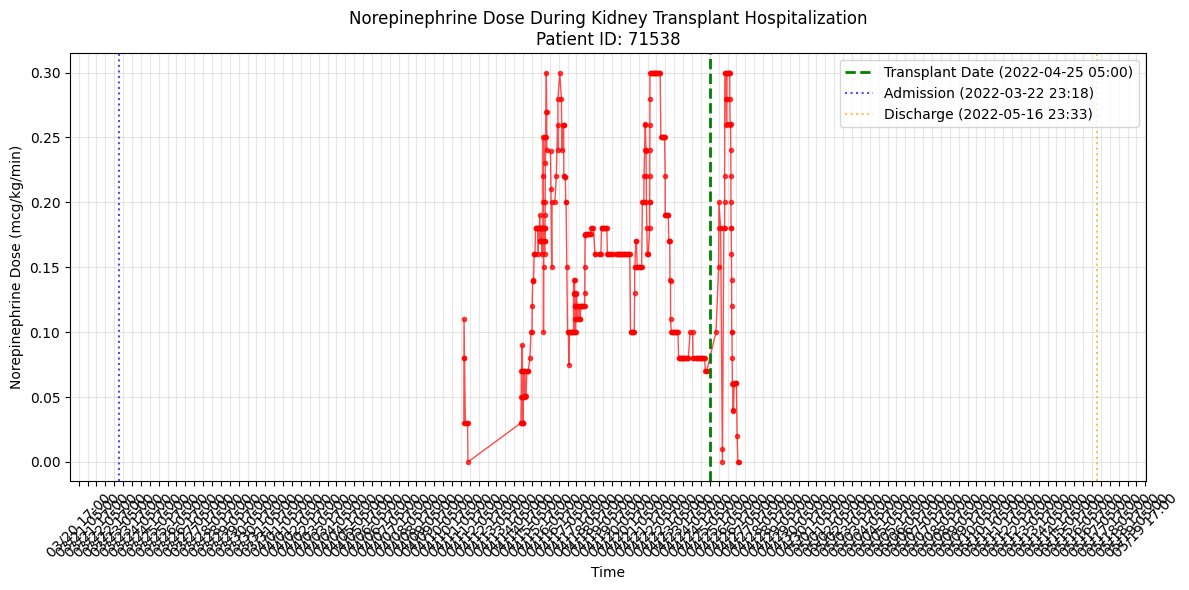

In [43]:
# Test the plotting function with a sample patient
# First, let's run the norepinephrine filtering code and find a patient with data

# Run the filtering code if not already executed
if 'transplant_norepinephrine' not in globals():
    print("Filtering norepinephrine data...")
    norepinephrine_df = med_cont_df[med_cont_df['med_category'] == 'norepinephrine'].copy()
    transplant_hosp_ids = transplant_hospitalization['hospitalization_id'].unique()
    transplant_norepinephrine = norepinephrine_df[norepinephrine_df['hospitalization_id'].isin(transplant_hosp_ids)].copy()

# Find patients with norepinephrine data during transplant hospitalization
if len(transplant_norepinephrine) > 0:
    # Get a sample patient with norepinephrine data
    sample_hosp_id = transplant_norepinephrine['hospitalization_id'].iloc[0]
    sample_patient_id = transplant_hospitalization[
        transplant_hospitalization['hospitalization_id'] == sample_hosp_id
    ]['patient_id'].iloc[0]
    
    print(f"Testing plot function with patient {sample_patient_id}")
    
    # Generate the plot
    fig = plot_norepinephrine_dose_hourly(
        sample_patient_id, 
        transplant_norepinephrine, 
        transplant_hospitalization
    )
    
    if fig is not None:
        plt.show()
    else:
        print("Could not generate plot for sample patient")
else:
    print("No norepinephrine data available for transplant patients")

In [ ]:
# Generate the plot
fig = plot_norepinephrine_dose_hourly(
    heart_transplant_ids[301], 
    transplant_norepinephrine, 
    transplant_hospitalization
)

if fig is not None:
    plt.show()
else:
    print("Could not generate plot for sample patient")

No norepinephrine data found for patient 32346 during transplant hospitalization
Could not generate plot for sample patient


Filtering dobutamine data for transplant patients...
Total dobutamine records: 296227
Dobutamine records in transplant hospitalizations: 52093
Sample hospitalization with dobutamine data: 632380077

Sample dobutamine data:
     hospitalization_id                admin_dttm  \
4967          632380077 2020-02-13 01:05:00+00:00   
4973          632380077 2020-02-13 04:40:00+00:00   
4976          632380077 2020-02-13 05:00:00+00:00   
4977          632380077 2020-02-13 06:00:00+00:00   
4982          632380077 2020-02-13 07:00:00+00:00   

                                               med_name med_category  \
4967  DOBUTAMINE 1,000 MG/250 ML(4,000 MCG/ML) IN 5 ...   dobutamine   
4973  DOBUTAMINE 1,000 MG/250 ML(4,000 MCG/ML) IN 5 ...   dobutamine   
4976  DOBUTAMINE 1,000 MG/250 ML(4,000 MCG/ML) IN 5 ...   dobutamine   
4977  DOBUTAMINE 1,000 MG/250 ML(4,000 MCG/ML) IN 5 ...   dobutamine   
4982  DOBUTAMINE 1,000 MG/250 ML(4,000 MCG/ML) IN 5 ...   dobutamine   

        med_group med_rou

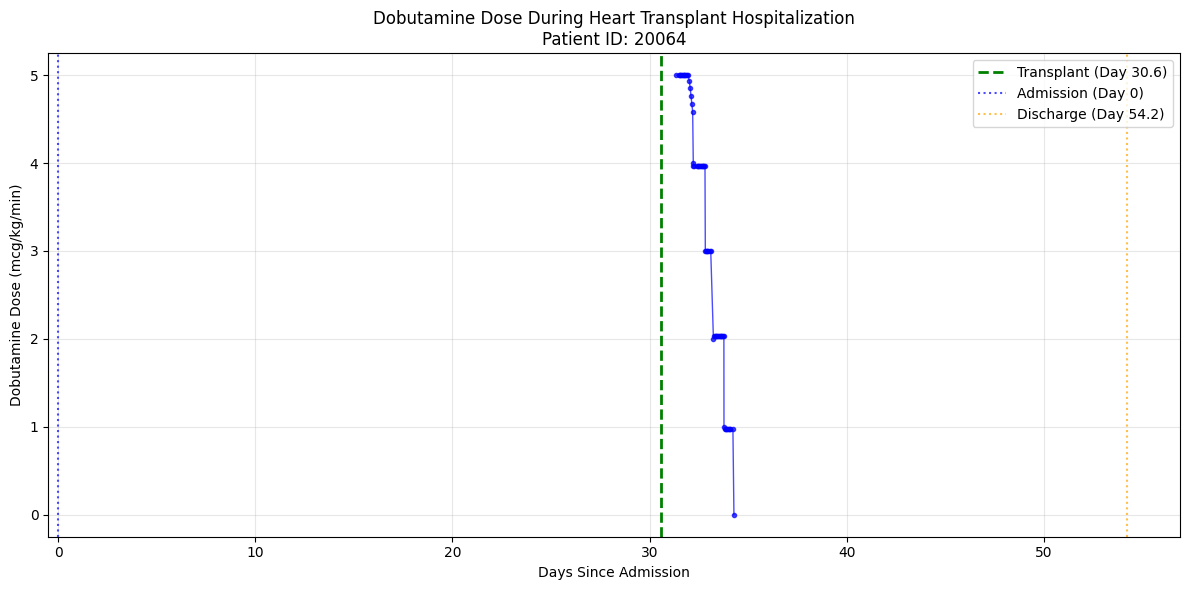

In [46]:
# Filter dobutamine medication data for transplant patients
print("Filtering dobutamine data for transplant patients...")

# Filter continuous medication for dobutamine
dobutamine_df = med_cont_df[med_cont_df['med_category'] == 'dobutamine'].copy()
print(f"Total dobutamine records: {len(dobutamine_df)}")

# Filter dobutamine data to transplant hospitalizations
transplant_dobutamine = dobutamine_df[dobutamine_df['hospitalization_id'].isin(transplant_hosp_ids)].copy()
print(f"Dobutamine records in transplant hospitalizations: {len(transplant_dobutamine)}")

# Check available patients with dobutamine data
if len(transplant_dobutamine) > 0:
    sample_patient_hosp = transplant_dobutamine['hospitalization_id'].iloc[0]
    print(f"Sample hospitalization with dobutamine data: {sample_patient_hosp}")
    
    # Show sample data
    print("\nSample dobutamine data:")
    print(transplant_dobutamine.head())
else:
    print("No dobutamine data found for transplant hospitalizations")

def plot_dobutamine_dose_hourly(patient_id, transplant_dobutamine_df, transplant_hospitalization_df, show_dates=False):
    """
    Plot dobutamine dose per hour during transplant hospitalization for a single patient.
    
    Parameters:
    patient_id (str): Patient ID to plot
    transplant_dobutamine_df (DataFrame): Filtered dobutamine data for transplant patients
    transplant_hospitalization_df (DataFrame): Transplant hospitalization data
    show_dates (bool): Whether to show actual dates in legend (default: False)
    
    Returns:
    matplotlib.figure.Figure: The plot figure
    """
    
    # Get patient's transplant hospitalization
    patient_hosp = transplant_hospitalization_df[
        transplant_hospitalization_df['patient_id'] == str(patient_id)
    ]
    
    if patient_hosp.empty:
        print(f"No transplant hospitalization found for patient {patient_id}")
        return None
    
    # Get hospitalization ID and transplant info
    hosp_id = patient_hosp.iloc[0]['hospitalization_id']
    transplant_date = patient_hosp.iloc[0]['transplant_date']
    organ_type = patient_hosp.iloc[0]['organ']
    admission_date = patient_hosp.iloc[0]['admission_dttm']
    discharge_date = patient_hosp.iloc[0]['discharge_dttm']
    
    # Filter dobutamine data for this hospitalization
    patient_dobutamine = transplant_dobutamine_df[
        transplant_dobutamine_df['hospitalization_id'] == hosp_id
    ].copy()
    
    if patient_dobutamine.empty:
        print(f"No dobutamine data found for patient {patient_id} during transplant hospitalization")
        return None
    
    # Convert admin_dttm to datetime and sort
    patient_dobutamine['admin_dttm'] = pd.to_datetime(patient_dobutamine['admin_dttm'])
    patient_dobutamine = patient_dobutamine.sort_values('admin_dttm')
    
    # Convert dates for calculations
    transplant_date = pd.to_datetime(transplant_date)
    admission_date = pd.to_datetime(admission_date)
    discharge_date = pd.to_datetime(discharge_date)
    
    # Calculate days since admission for all timepoints
    patient_dobutamine['days_since_admission'] = (patient_dobutamine['admin_dttm'] - admission_date).dt.total_seconds() / (24 * 3600)
    transplant_days = (transplant_date - admission_date).total_seconds() / (24 * 3600)
    discharge_days = (discharge_date - admission_date).total_seconds() / (24 * 3600)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot dobutamine dose over time
    ax.plot(patient_dobutamine['days_since_admission'], patient_dobutamine['med_dose'], 
            marker='o', markersize=3, linewidth=1, color='blue', alpha=0.7)
    
    # Add vertical line for transplant date
    if show_dates:
        transplant_label = f'Transplant Date ({transplant_date.strftime("%Y-%m-%d %H:%M")})'
    else:
        transplant_label = f'Transplant (Day {transplant_days:.1f})'
    ax.axvline(x=transplant_days, color='green', linestyle='--', linewidth=2, label=transplant_label)
    
    # Add vertical lines for admission and discharge
    if show_dates:
        admission_label = f'Admission ({admission_date.strftime("%Y-%m-%d %H:%M")})'
        discharge_label = f'Discharge ({discharge_date.strftime("%Y-%m-%d %H:%M")})'
    else:
        admission_label = 'Admission (Day 0)'
        discharge_label = f'Discharge (Day {discharge_days:.1f})'
    
    ax.axvline(x=0, color='blue', linestyle=':', alpha=0.7, label=admission_label)
    ax.axvline(x=discharge_days, color='orange', linestyle=':', alpha=0.7, label=discharge_label)
    
    # Formatting
    ax.set_xlabel('Days Since Admission')
    ax.set_ylabel('Dobutamine Dose (mcg/kg/min)')
    ax.set_title(f'Dobutamine Dose During {organ_type.title()} Transplant Hospitalization\n'
                 f'Patient ID: {patient_id}')
    
    # Set x-axis to show clean day intervals
    ax.set_xlim(left=-0.5)  # Start slightly before admission
    
    # Add legend
    ax.legend()
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    
    # Print summary statistics
    print(f"Patient {patient_id} - {organ_type.title()} Transplant:")
    print(f"  Hospitalization ID: {hosp_id}")
    print(f"  Admission: {admission_date}")
    print(f"  Transplant: {transplant_date} (Day {transplant_days:.1f})")
    print(f"  Discharge: {discharge_date} (Day {discharge_days:.1f})")
    print(f"  Dobutamine records: {len(patient_dobutamine)}")
    print(f"  Dose range: {patient_dobutamine['med_dose'].min():.2f} - {patient_dobutamine['med_dose'].max():.2f} mcg/kg/min")
    print(f"  Mean dose: {patient_dobutamine['med_dose'].mean():.2f} mcg/kg/min")
    
    return fig

# Test the dobutamine plotting function with a sample patient
if len(transplant_dobutamine) > 0:
    # Get a sample patient with dobutamine data
    sample_hosp_id = transplant_dobutamine['hospitalization_id'].iloc[0]
    sample_patient_id = transplant_hospitalization[
        transplant_hospitalization['hospitalization_id'] == sample_hosp_id
    ]['patient_id'].iloc[0]
    
    print(f"\nTesting dobutamine plot function with patient {sample_patient_id}")
    
    # Generate the plot
    fig = plot_dobutamine_dose_hourly(
        sample_patient_id, 
        transplant_dobutamine, 
        transplant_hospitalization
    )
    
    if fig is not None:
        plt.show()
    else:
        print("Could not generate dobutamine plot for sample patient")
else:
    print("No dobutamine data available for transplant patients - cannot test plotting function")

Patient 147219 - Heart Transplant:
  Hospitalization ID: 645102706
  Admission: 2023-12-14 23:25:00+00:00
  Transplant: 2024-02-19 06:00:00+00:00 (Day 66.3)
  Discharge: 2024-03-15 20:14:00+00:00 (Day 91.9)
  Dobutamine records: 98
  Dose range: 0.00 - 5.00 mcg/kg/min
  Mean dose: 4.31 mcg/kg/min


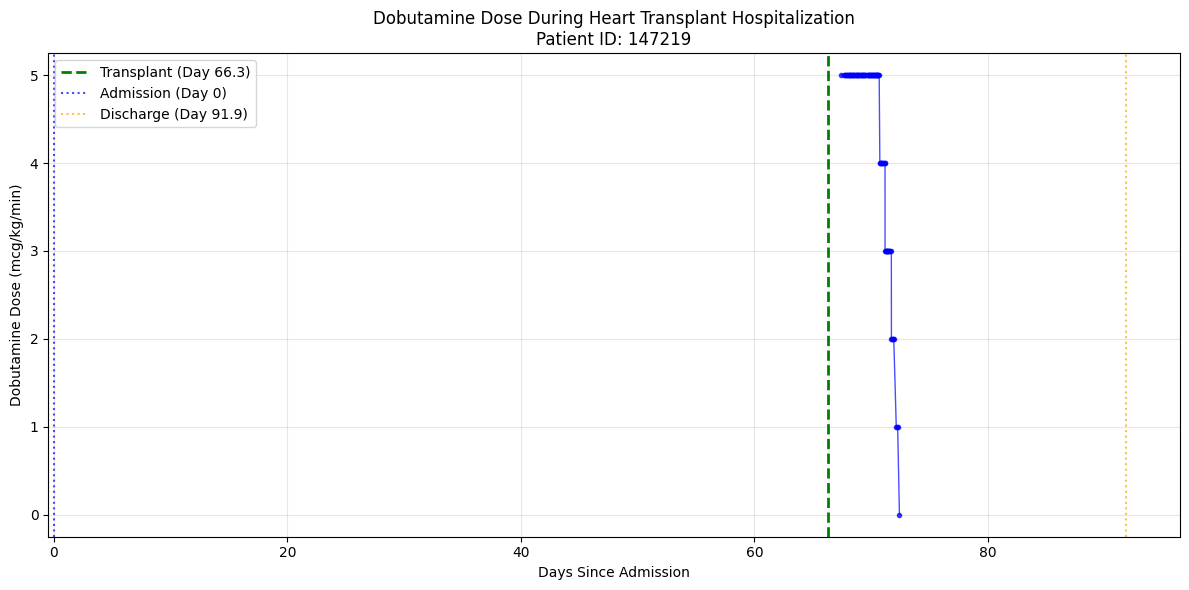

In [51]:
fig = plot_dobutamine_dose_hourly(heart_transplant_ids[302], transplant_dobutamine, transplant_hospitalization)